## Verlan optimization scheme for LDOS maximization
In this tutorial, we show how to use the Verlan optimization scheme to get initializaitons for topology optimization, using the LDOS problem as an example. This will yield two things: (1) a bound on the optimal performance of the objective and (2) a good initialization for the topology optimization problem. For more information on Verlan, see the main review paper associated with this repository. 

The original Verlan papers are:
1. *Bounds as blueprints: towards optimal and accelerated photonic inverse design* by Chao*, P., Amaolo*, A., Molesky, S., Rodriguez, A. W. 
2. *Inferring Structure via Duality for Photonic Inverse Design* by Molesky, S., Chao, P., Amaolo, A., Rodriguez, A. W.

You should first see examples/limits/LDOS.ipynb and LDOS_gcd.ipynb to understand how to set up the LDOS problem, which will not be covered in detail here.

### Part 1: Simplest Verlan initialization

In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 2
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics

wavelength = 1.0 # Dolphindes uses dimensionless units. 
omega = 2 * np.pi / wavelength
chi = 4+1e-4j # Design material 
px_per_length = 40 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1/px_per_length 
Npmlsep = int(0.5 / dl) # gap between design region and PML. Not required to be defined, it is just convenient.
Npmlx, Npmly = int(0.5 / dl), int(0.5 / dl) # PML size.
Mx, My = int(3.0 / dl), int(3.0 / dl) # design mask size 
Dx = int(0.1 / dl) # distance from the design region to the source region.
Nx, Ny = int(Npmlx*2 + Npmlsep*2 + Dx + Mx), int(Npmly*2 + Npmlsep*2 + My) # grid size. This includes the pml layer!

cx, cy = Npmlx + Npmlsep, Ny//2

ji = np.zeros((Nx, Ny), dtype=complex) # current density
ji[cx, cy] = 1.0/dl/dl # a delta function source in 2D is approximated by amplitude 1/dl/dl so that integration int(ji)dxdy = 1.0. 

# TODO(alessio): Move design mask making utilities to geometry_utils.py.
design_mask = np.zeros((Nx, Ny), dtype=bool) # design mask
design_mask[Npmlx + Npmlsep + Dx: Npmlx + Npmlsep + Dx + Mx, Npmly + Npmlsep: Npmly + Npmlsep + My] = True # design mask
ndof = np.sum(design_mask) # number of degrees of freedom in the design region

chi_background = np.zeros((Nx, Ny), dtype=complex) # background material
chi_background[:, :] = 0

In [4]:
ldos_problem = photonics.Photonics_TM_FDFD(omega = omega, chi = chi, grid_size = (Nx, Ny), pml_size = (Npmlx, Npmly), dl = dl,
    des_mask = design_mask, ji=ji, chi_background=chi_background, sparseQCQP=True, A0=None, s0=None, c0=0.0)


In [ ]:
ei = ldos_problem.get_ei(ji, update=True) # update = true sets the ei to the source field. Not required if you just need to do a Maxwell solve. 

vac_ldos = -np.sum(1/2 * np.real(ji.conj() * ei) * dl * dl)
print("Vacuum LDOS: ", vac_ldos)

ei_design = ei[ldos_problem.des_mask] # restrict the field to the design region
s0 = - (1/4) * 1j * omega * ei_design.conj() * dl * dl
A0 = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))

# We set the objective with set_objective(). 
ldos_problem.set_objective(s0=s0, A0=A0, c0=0.0) 

The more projections you use to set up the LDOS problem, the more local physics will be included, making a better Verlan initialization more likely. By setting up 'global' projections, you may recover the 'global' Verlan initializations in our paper. 

Here, we will use the GCD projection optimization to get "local"-like constraints for large systems. This is meant to mimic fully local constraints without so many projections, and therefore give fast Verlan initializations.

In [6]:
ldos_problem.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.

t = time.time()
gcd_tol = 1e-2
ldos_problem.QCQP.run_gcd(gcd_tol=1e-2)
print(f'gcd with gcd_tol={gcd_tol} took time {time.time()-t}.')

/home/alessio/code/dolphindes/dolphindes/photonics/photonics.py:194: UserWarning: If both ji and ei are specified then ji is ignored.
  warnings.warn("If both ji and ei are specified then ji is ignored.")


Precomputed 2 A matrices for the projectors.


/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:475: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:475: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:520: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  tmp = self.Acho.cholesky(A)
/home/alessio/code/dolphindes/dolphindes/cvxopt/qcqp.py:486: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Acho.cholesky_inplace(A)


Found feasible point for dual problem: [8.4512876e-07 2.2500000e-01] with dualvalue 72072.482008604
Precomputed 2 A matrices for the projectors.
At GCD iteration #1, best dual bound found is 2403.2508230418507.
At GCD iteration #2, best dual bound found is 2035.918057896979.
At GCD iteration #3, best dual bound found is 2010.6428093832133.
At GCD iteration #4, best dual bound found is 1998.5955230534157.
At GCD iteration #5, best dual bound found is 1968.2810093656399.
At GCD iteration #6, best dual bound found is 1963.6557898861251.
At GCD iteration #7, best dual bound found is 1962.876610123439.
At GCD iteration #8, best dual bound found is 1963.3602808927203.
At GCD iteration #9, best dual bound found is 1954.0027958106946.
At GCD iteration #10, best dual bound found is 1951.5352904295835.
gcd with gcd_tol=0.01 took time 6310.342964410782.


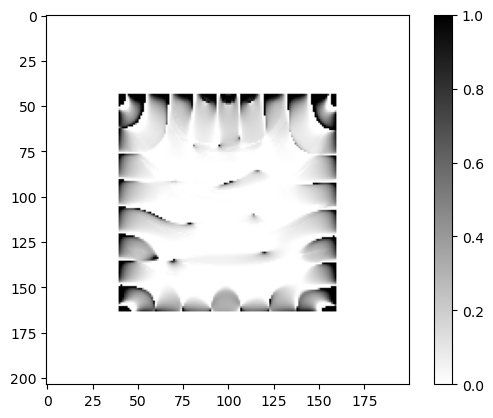

In [ ]:
%autoreload 2
from dolphindes.util import geometry_utils

# Let's have a look at the inferred chi from the GCD optimization
# Since this particular run takes about an hour, we've provided a reference npy chi_inferred.npy 
try:
    chi_inf = ldos_problem.get_chi_inf()
    # np.save('reference_arrays/chi_inferred.npy', ldos_problem.get_chi_inf())  # Uncomment if you want to over-write chi
except:
    chi_inf = np.load('reference_arrays/chi_inferred.npy')

rho_feas = photonics.chi_to_feasible_rho(chi_inf, ldos_problem.chi)
embedded_rho = geometry_utils.embed_vector(ldos_problem.des_mask, rho_feas)
plt.imshow(embedded_rho, cmap='binary', vmin=0, vmax=1)
plt.colorbar()

verlan_init_local = rho_feas.copy()

That's it, that is the simplest "Verlan" method: solve the not-strongly-dual dual problem, and use the infeasible chi projected to the nearest feasible point as the initialization for the topology optimization problem. These results already resemble the initializations in reference [1] above.

### Part 2: Scraping and forcing strong duality

We may perform the "scraping" procedure to get strong duality by changing the objective. This is not yet implemented in Dolphindes, but will be soon!

For a comparison of Verlan initializations with topopt from random initializations, see examples/verlan/verlan_topopt_comparison.ipynb.

In [ ]:
# Saving parameters for the verlan_topopt_comparison notebook

parameter_dict = {
    'chi': chi,
    'omega': omega,
    'wavelength': wavelength,
    'px_per_length': px_per_length,
    'Npmlsep': Npmlsep,
    'Npmlx': Npmlx,
    'Npmly': Npmly,
    'Mx': Mx,
    'My': My,
    'Dx': Dx,
    'Nx': Nx,
    'Ny': Ny,
}

import pickle

with open('reference_arrays/parameters.pkl', 'wb') as f:
    pickle.dump(parameter_dict, f)